
## Demonstrate that there are no biases in the current generated data i.e. one can see plugged motifs with simpler tools.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import mubind as mb
import numpy as np

### Tests of the network with simulated data

In [1]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import torch.nn as tnn
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [3]:
# motif = 'AGGAACCTA'
motif = 'GATA'
# SELEX
# x1, y1 = mb.datasets.simulate_xy(motif, n_trials=20000, seqlen=20, max_mismatches=5)
# ChIP-seq
x2, y2 = mb.datasets.simulate_xy(motif, n_trials=10000, seqlen=200, max_mismatches=2)
# y2 = ((y2 - y2.min()) / (np.max(y2) - np.min(y2))).astype(np.float32)

In [4]:
x2.shape, y2.shape

((10000,), (10000,))

In [5]:
pos = x2[y2 == y2.max()]
neg = x2[y2 != y2.max()]
print(pos.shape, neg.shape)

(5000,) (5000,)


In [7]:
import itertools


freq = []
for seqs, label in zip([pos, neg], [1, 0]):
    for k in range(2, 5):
        options = {''.join(opt): 0 for opt in itertools.product('ACTG', repeat=k)}
        for si, s in enumerate(seqs):
            for i in range(len(s) - k + 1):
                # print(i, k)
                kmer = s[i: i + k]
                # print(kmer)
                options[kmer] += 1
        df = pd.DataFrame(options.items(), columns=['kmer', 'counts'])
        df['prob'] = df['counts'] / df['counts'].sum()
        df['label'] = label
        freq.append(df)
    
freq = pd.concat(freq)
freq['k'] = freq['kmer'].str.len()
di = freq[freq['k'] == 2]
tr = freq[freq['k'] == 4]

In [8]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 2
rcParams['figure.dpi'] = 110

<AxesSubplot:xlabel='kmer', ylabel='label'>

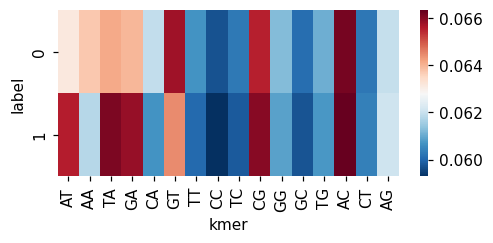

In [9]:
from matplotlib import rcParams

hm = di.pivot('label', 'kmer', 'prob').T
dev = (hm[1] - hm[0]).abs() / hm.mean(axis=1)
hm['dev'] = dev
hm = hm.sort_values('dev', ascending=0)
del hm['dev']
sns.heatmap(hm.T, cmap='RdBu_r')

<AxesSubplot:xlabel='kmer', ylabel='label'>

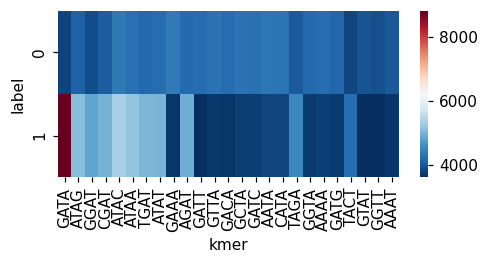

In [12]:
hm = tr.pivot('label', 'kmer', 'counts').T
dev = (hm[1] - hm[0]).abs() / hm.mean(axis=1)
hm['dev'] = dev
hm = hm.sort_values('dev', ascending=0)
del hm['dev']

from matplotlib import rcParams
sns.heatmap(hm.head(25).T, cmap='RdBu_r', xticklabels=1)

In [14]:
pos = x2[y2 == y2.max()]
neg = x2[y2 != y2.max()]

for p, seqs in zip(['../data/pos.fa', '../data/neg.fa'], [pos, neg]):
    print(p, len(seqs))
    writer = open(p, 'w')
    for si, s in enumerate(seqs):
        writer.write('>%s\n%s\n' % (si, s))
    writer.close()
    

../data/pos.fa 5000
../data/neg.fa 5000


In [ ]:
!findMotifs.pl ../data/pos.fa fasta ../data/motifResults/ -fasta ../data/neg.fa

In [6]:
p = pd.DataFrame({'seq': pos, 'target': 1})
n = pd.DataFrame({'seq': neg, 'target': 0})
data = pd.concat([p, n])
data.index = range(len(data))
data

,seq,target
0,GGTGCATAACTCGTAATGTTCGACTCTTTGCAACGGCGGGCGTTAG...,1
1,CTATTGCACTCTGTGAACTTAAACCATTCTCGTCGTTTAGATGTCG...,1
2,GACTATAACAGCGCAACGTCACACTCCCACATCGGTTTAGTCATAC...,1
3,CGCAAGGATCACCTCGAAGATGATATGCTTACCCAGACGGTAGTGA...,1
4,AATTTTTTAAGCTCTGTATAGGGTACCATCTCCGGCGGCCTATCTA...,1
...,...,...
9995,ACTGAACAAATATGATCGATAGTTAGTTAATTAGACATCAGATATT...,0
9996,CGTCCGATACCGTTAATTATGGTAGGTAAGGCAGCGATGCAACGGT...,0
9997,ATAATATACCCGACCCATGGTAGGATCGGTCAAATATAAATCACAT...,0
9998,AGCTGGTTAATACAACGAAGGAAAAACCTATCTGTGTTATCAAGGC...,0


In [7]:
test_dataframe = data.sample(frac=0.01)
train_dataframe = data.drop(test_dataframe.index)

test_dataframe.index = range(len(test_dataframe))
train_dataframe.index = range(len(train_dataframe))

train_data = mb.tl.ChipSeqDataset(data_frame=train_dataframe, use_dinuc=False)
train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_data = mb.tl.ChipSeqDataset(data_frame=test_dataframe, use_dinuc=False)
test_loader = tdata.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [8]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = tnn.BCELoss()
loss_history = []

In [13]:
loss_history += mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.499
Epoch:  2, Loss: 0.499
Epoch:  3, Loss: 0.498
Epoch:  4, Loss: 0.498
Epoch:  5, Loss: 0.498
Epoch:  6, Loss: 0.499
Epoch:  7, Loss: 0.498
Epoch:  8, Loss: 0.498
Epoch:  9, Loss: 0.498
Epoch: 10, Loss: 0.498
Epoch: 11, Loss: 0.499
Epoch: 12, Loss: 0.498
Epoch: 13, Loss: 0.498
Epoch: 14, Loss: 0.498
Epoch: 15, Loss: 0.498
Epoch: 16, Loss: 0.498
Epoch: 17, Loss: 0.498
Epoch: 18, Loss: 0.499
Epoch: 19, Loss: 0.499
Epoch: 20, Loss: 0.499
Epoch: 21, Loss: 0.498
Epoch: 22, Loss: 0.498
Epoch: 23, Loss: 0.498
Epoch: 24, Loss: 0.499
Epoch: 25, Loss: 0.498
Epoch: 26, Loss: 0.499
Epoch: 27, Loss: 0.498
Epoch: 28, Loss: 0.499
Epoch: 29, Loss: 0.498
Epoch: 30, Loss: 0.498
Epoch: 31, Loss: 0.499
Epoch: 32, Loss: 0.498
Epoch: 33, Loss: 0.498
Epoch: 34, Loss: 0.499
Epoch: 35, Loss: 0.499
Epoch: 36, Loss: 0.498
Epoch: 37, Loss: 0.499
Epoch: 38, Loss: 0.498
Epoch: 39, Loss: 0.498
Epoch: 40, Loss: 0.498
Epoch: 41, Loss: 0.498
Epoch: 42, Loss: 0.498
Epoch: 43, Loss: 0.498
Epoch: 44, 

0.0028596374


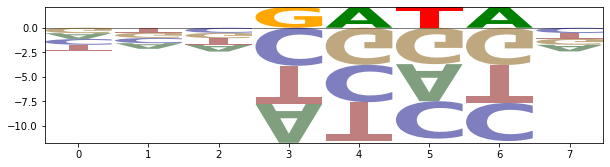

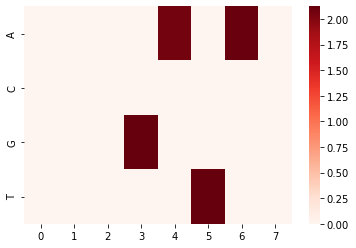

In [14]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

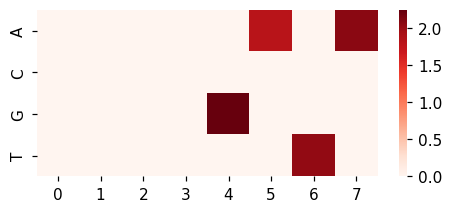

In [30]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

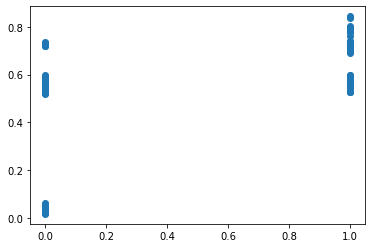

In [15]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["mononuc"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.5269325
0.70049936


<AxesSubplot:>

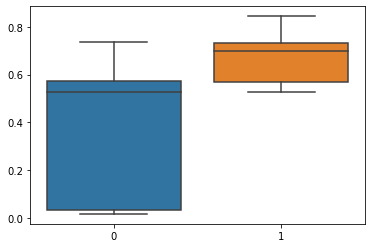

In [16]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

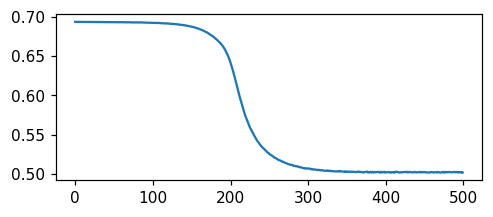

In [33]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

In [34]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = tnn.BCELoss()
loss_history = []

0.004991593


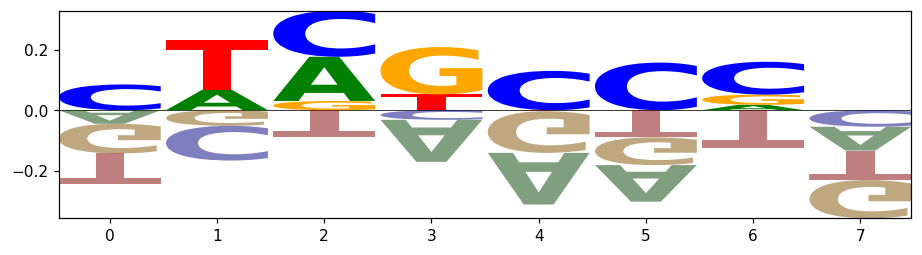

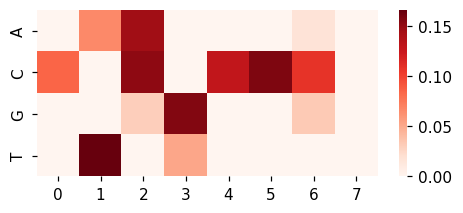

In [35]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

In [40]:
loss_history += mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.494
Epoch:  2, Loss: 0.494
Epoch:  3, Loss: 0.494
Epoch:  4, Loss: 0.494
Epoch:  5, Loss: 0.494
Epoch:  6, Loss: 0.494
Epoch:  7, Loss: 0.494
Epoch:  8, Loss: 0.494
Epoch:  9, Loss: 0.494
Epoch: 10, Loss: 0.494
Epoch: 11, Loss: 0.494
Epoch: 12, Loss: 0.493
Epoch: 13, Loss: 0.494
Epoch: 14, Loss: 0.494
Epoch: 15, Loss: 0.494
Epoch: 16, Loss: 0.494
Epoch: 17, Loss: 0.494
Epoch: 18, Loss: 0.494
Epoch: 19, Loss: 0.493
Epoch: 20, Loss: 0.494
Epoch: 21, Loss: 0.494
Epoch: 22, Loss: 0.494
Epoch: 23, Loss: 0.494
Epoch: 24, Loss: 0.494
Epoch: 25, Loss: 0.494
Epoch: 26, Loss: 0.494
Epoch: 27, Loss: 0.493
Epoch: 28, Loss: 0.494
Epoch: 29, Loss: 0.494
Epoch: 30, Loss: 0.494
Epoch: 31, Loss: 0.494
Epoch: 32, Loss: 0.494
Epoch: 33, Loss: 0.494
Epoch: 34, Loss: 0.494
Epoch: 35, Loss: 0.494
Epoch: 36, Loss: 0.494
Epoch: 37, Loss: 0.494
Epoch: 38, Loss: 0.494
Epoch: 39, Loss: 0.494
Epoch: 40, Loss: 0.494
Epoch: 41, Loss: 0.494
Epoch: 42, Loss: 0.493
Epoch: 43, Loss: 0.493
Epoch: 44, 

0.002904073


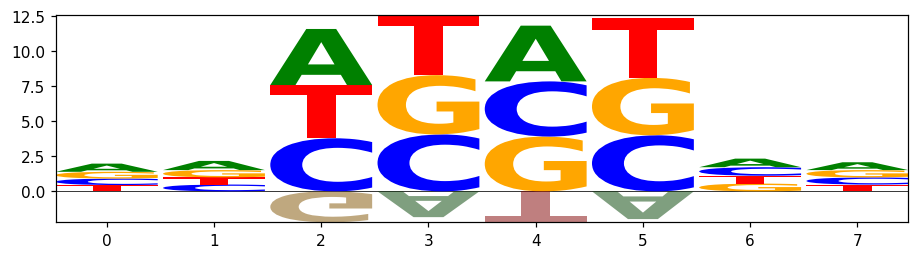

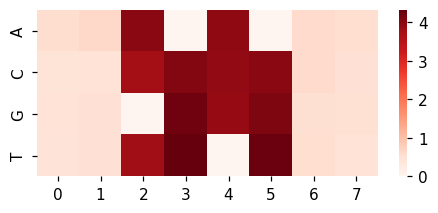

In [41]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

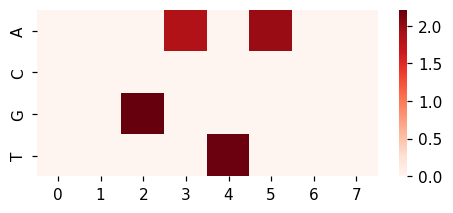

In [42]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

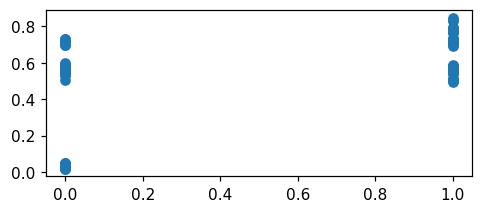

In [43]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["mononuc"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.5486757
0.58566654


<AxesSubplot:>

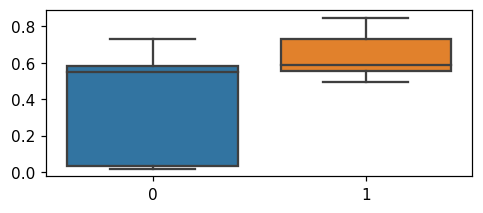

In [44]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

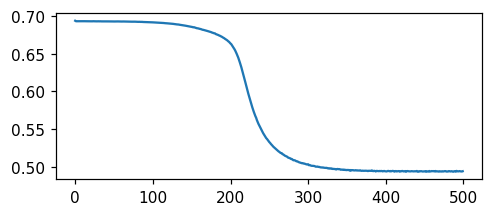

In [45]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

In [37]:
train_100_dataframe['has.GATA'] = train_100_dataframe['seq'].str.contains('GATA')
train_100_dataframe.groupby('target').sum()

,has.GATA
target,
0.0,15
1.0,45
